In [1]:
%config IPCompleter.greedy=True
%matplotlib notebook
import libs.lib as lib
lib.setup_logger('info', logfile='/home/adebahr/apercal/ipython-notebooks/commissioning/01/17122123_3C286_0.log')
import apercal

/home/apercal/pipeline/local/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa
root - INFO : Logging started!
root - INFO : To see the log in a bash window use the following command:
root - INFO : tail -n +1 -f /home/adebahr/apercal/ipython-notebooks/commissioning/01/17122123_3C286_0.log


Setup logger with lib.setup_logger()


In [2]:
prepare = apercal.prepare('/home/adebahr/apercal/ipython-notebooks/commissioning/01/17122123_3C286_0.cfg')
prepare.go()

PREPARE - INFO : ### Configuration file /home/adebahr/apercal/ipython-notebooks/commissioning/01/17122123_3C286_0.cfg successfully read! ###
PREPARE - INFO : ########## Preparing data for calibration ##########
PREPARE - INFO : ### Flux calibrator dataset found. Copying beam 00 to working directory. ###
PREPARE - WARNING : ### No polarisation calibrator dataset specified. The next steps might not work! ###
PREPARE - INFO : ########## Data prepared for calibration ##########


In [3]:
preflag = apercal.preflag('/home/adebahr/apercal/ipython-notebooks/commissioning/01/17122123_3C286_0.cfg')
nchannel = 11008

# Make lists of the channels which are affected
a = range(0, nchannel, 64) # the subband edges
b = range(1, nchannel, 64)
c = range(63, nchannel, 64)
d = range(16, nchannel, 64) # the two ghosts
e = range(48, nchannel, 64)
# Combine the channel list into one list and convert to a string
l = a + b + c + d + e
preflag.preflag_manualflag_channel = ';'.join(str(ch) for ch in l)

preflag.manualflag()

In [4]:
preflag.aoflagger_bandpass()

TypeError: a float is required

In [5]:
preflag.aoflagger_flag()

In [6]:
convert = apercal.convert('/home/adebahr/apercal/ipython-notebooks/commissioning/01/17122123_3C286_0.cfg')
convert.go()

CONVERT - INFO : ### Configuration file /home/adebahr/apercal/ipython-notebooks/commissioning/01/17122123_3C286_0.cfg successfully read! ###
CONVERT - INFO : ########## FILE CONVERSION started ##########
CONVERT - INFO : ### Starting conversion from MS to UVFITS format ###
CONVERT - INFO : ### Converted MS file 3C286.MS to UVFITS format! ###
CONVERT - INFO : ### Conversion from MS to UVFITS format done! ###
CONVERT - INFO : ### Starting conversion from UVFITS to MIRIAD format ###
CONVERT - INFO : ### Converted UVFITS file 3C286.MS to MIRIAD format! ###
CONVERT - INFO : ### Conversion from UVFITS to MIRIAD format done! ###
CONVERT - INFO : ########## FILE CONVERSION done ##########


In [2]:
ccal = apercal.ccal('/home/adebahr/apercal/ipython-notebooks/commissioning/01/17122123_3C286_0.cfg')

CROSSCAL - INFO : ### Configuration file /home/adebahr/apercal/ipython-notebooks/commissioning/01/17122123_3C286_0.cfg successfully read! ###


In [3]:
# Set the parameters for the bandpass calibration
gainint = '60' # Solution interval for calibrator gains
gapint = '60' # Maximum time gap in data until a new solution interval starts
bpint = '60' # Solution interval for the bandpass

# Execute the bandpass calibration
mfcal = lib.miriad('mfcal')
mfcal.vis = ccal.fluxcal
# Comment the next line out if you don't want to solve for delays
mfcal.options = 'delay'
mfcal.stokes = 'XX'
mfcal.interval = gainint + ',' + gapint + ',' + bpint
mfcal.tol = 0.1 # Set the tolerance a bit lower. Otherwise mfcal takes a long time to finsh
mfcal.go()

['MfCal: $Revision: 1.20 $, $Date: 2017/05/08 02:31:10 $']

In [4]:
import subs.readmirlog
values, freqs = subs.readmirlog.get_bp(ccal.crosscaldir + '/' + ccal.fluxcal)
# The bandpass results are ordered in a 3D numpy array called values in the following order: antenna, frequency, solution interval
# freqs gives you a list of the frequencies

<IPython.core.display.Javascript object>


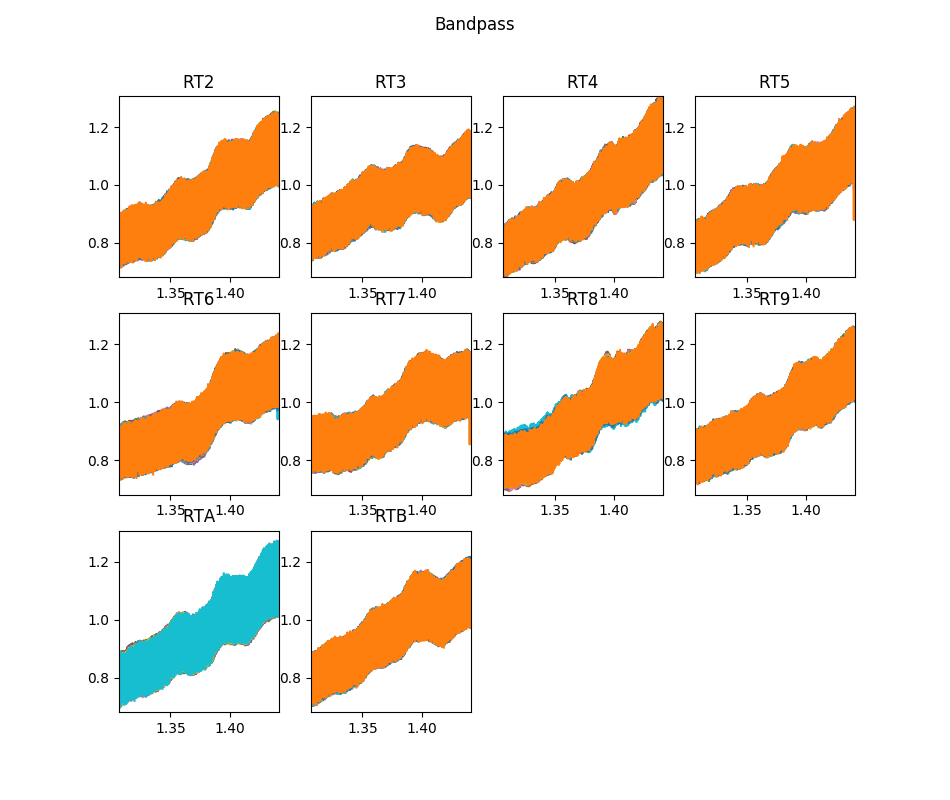

In [8]:
# You can plot all solution intervals for each antenna in one subplot each
from matplotlib import pyplot as plt
import numpy as np
values[values==0] = np.nan # Replace all zeros with nan
plt.figure(figsize=(9.5,8))
plt.xlim(np.min(freqs),np.max(freqs)) # Limit the plot to the minimum and maximum frequencies
plt.suptitle('Bandpass', fontsize='large')

# Define an array with the telescope names
tnames = ['RT2','RT3','RT4','RT5','RT6','RT7','RT8','RT9','RTA','RTB']

for a in range(len(values[:])):
    plt.subplot(np.ceil(len(tnames)/4.0), 4, a+1)
    plt.plot(freqs, values[a,:,:])
    plt.title(tnames[a])
    plt.xlim(np.min(freqs),np.max(freqs)) # Limit the plot to the minimum and maximum frequencies
    plt.ylim(np.nanmin(values), np.nanmax(values))
    plt.show()

/home/apercal/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


<IPython.core.display.Javascript object>


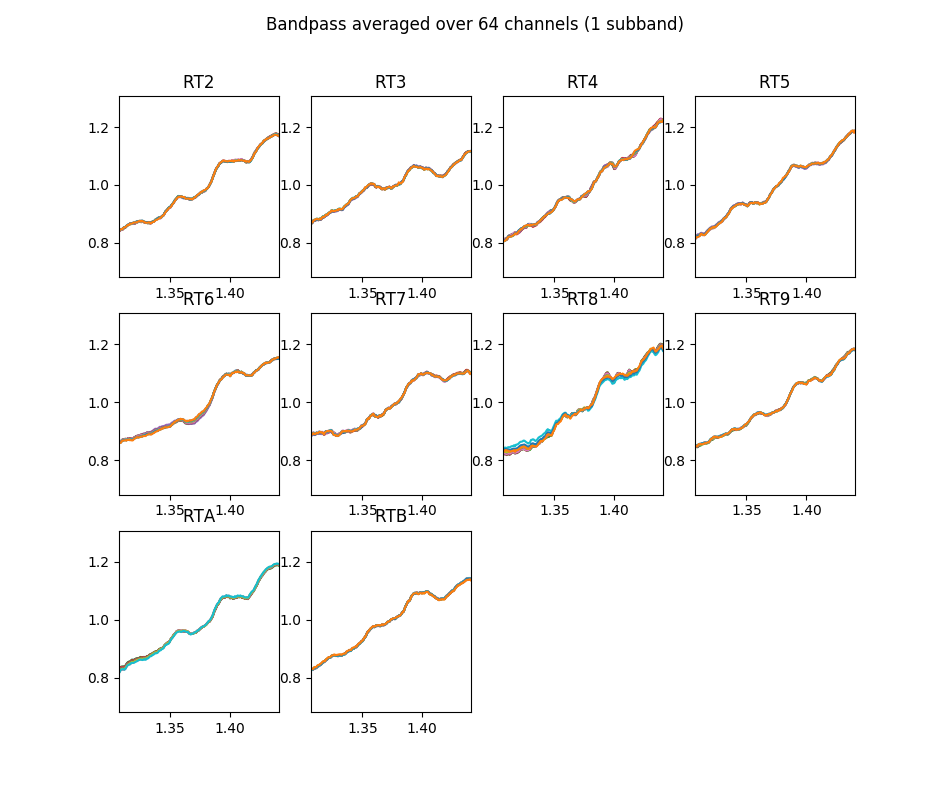

In [9]:
# The bandpass might be better visualised by averaging over each subband of 64 channels

values[values==0] = np.nan # Replace all zeros with nan
avvalues = values.reshape(values.shape[0],-1, 64,values.shape[2]) # Reshape the second axis of the array
avmean = np.nanmean(avvalues, axis=2) # Calculate the mean over the new axis
avfreqs = np.nanmean(freqs.reshape(-1,64), axis=1) # Adjust the size of the freqeucny axis to the new shape

# Now create the same plot as above
plt.figure(figsize=(9.5,8))
plt.xlim(np.min(freqs),np.max(freqs)) # Limit the plot to the minimum and maximum frequencies
plt.suptitle('Bandpass averaged over 64 channels (1 subband)', fontsize='large')

for a in range(len(avvalues[:])):
    plt.subplot(np.ceil(len(tnames)/4.0), 4, a+1)
    plt.plot(avfreqs, avmean[a,:,:])
    plt.title(tnames[a])
    plt.xlim(np.min(avfreqs),np.max(avfreqs)) # Limit the plot to the minimum and maximum frequencies
    plt.ylim(np.nanmin(avvalues), np.nanmax(avvalues))
    plt.show()

In [10]:
# Let's fit a polynomial to the bandpass using the average of all solution intervals
polyorder = 3 # Order of the fitted polynomial
for a in range(len(tnames)):
    fitvalues = np.poly1d(np.polyfit(avfreqs, np.nanmean(avmean[a], axis=1), deg=polyorder)) # Fit a polynomial to all telescopes at once
    print(tnames[a])
    print(fitvalues)

RT2
        3       2
-138.6 x + 577 x - 797.8 x + 367.3
RT3
       3         2
100.8 x - 422.4 x + 591.1 x - 275.2
RT4
       3         2
67.57 x - 270.2 x + 362.6 x - 162.5
RT5
       3         2
69.25 x - 284.3 x + 391.4 x - 179.8
RT6
      3        2
-284 x + 1178 x - 1625 x + 746.7
RT7
      3        2
-437 x + 1801 x - 2470 x + 1129
RT8
        3         2
-171.9 x + 711.9 x - 979.3 x + 448.4
RT9
       3         2
-20.9 x + 92.84 x - 134.2 x + 64.26
RTA
       3         2
16.57 x - 62.21 x + 79.83 x - 34.23
RTB
        3       2
-153.3 x + 625 x - 846.2 x + 381.5


<IPython.core.display.Javascript object>


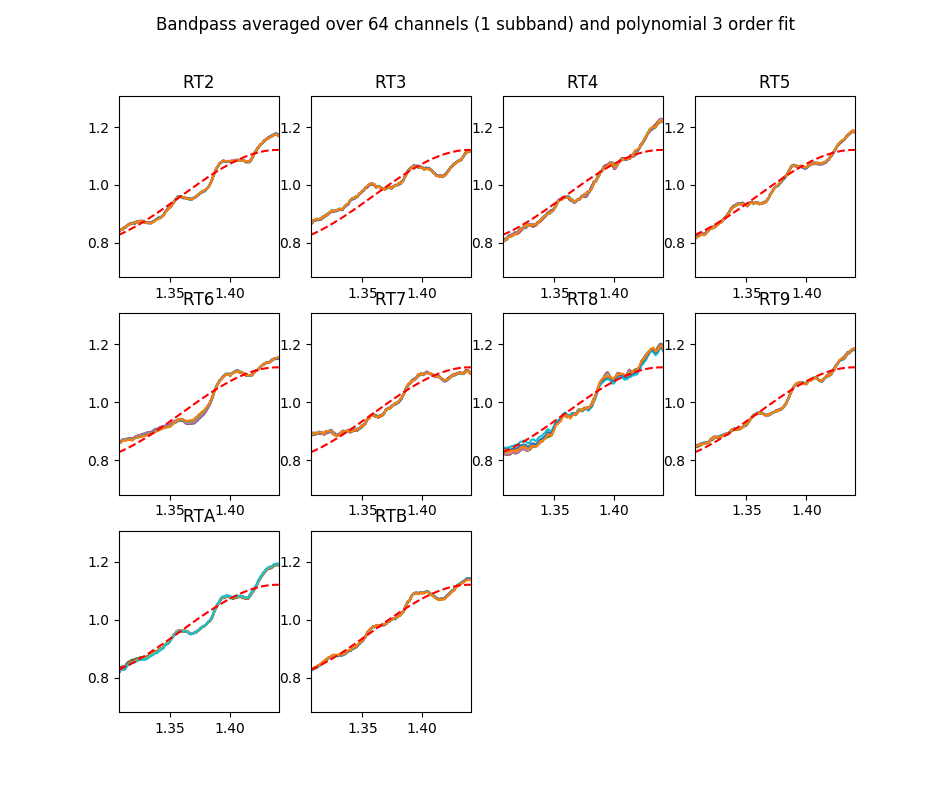

In [12]:
# Plot the bandpass plus the fitted solutions

# Fill the fit with values to plot
xp = np.linspace(np.min(freqs),np.max(freqs),len(avfreqs))

plt.figure(figsize=(9.5,8))
plt.xlim(np.min(freqs),np.max(freqs)) # Limit the plot to the minimum and maximum frequencies
plt.suptitle('Bandpass averaged over 64 channels (1 subband) and polynomial ' + str(polyorder) + ' order fit', fontsize='large')

for a in range(len(avvalues[:])):
    plt.subplot(np.ceil(len(tnames)/4.0), 4, a+1)
    plt.plot(avfreqs, avmean[a,:,:])
    plt.plot(avfreqs, fitvalues(avfreqs),'--',c='r')
    plt.title(tnames[a])
    plt.xlim(np.min(avfreqs),np.max(avfreqs)) # Limit the plot to the minimum and maximum frequencies
    plt.ylim(np.nanmin(avvalues), np.nanmax(avvalues))
    plt.show()

<IPython.core.display.Javascript object>


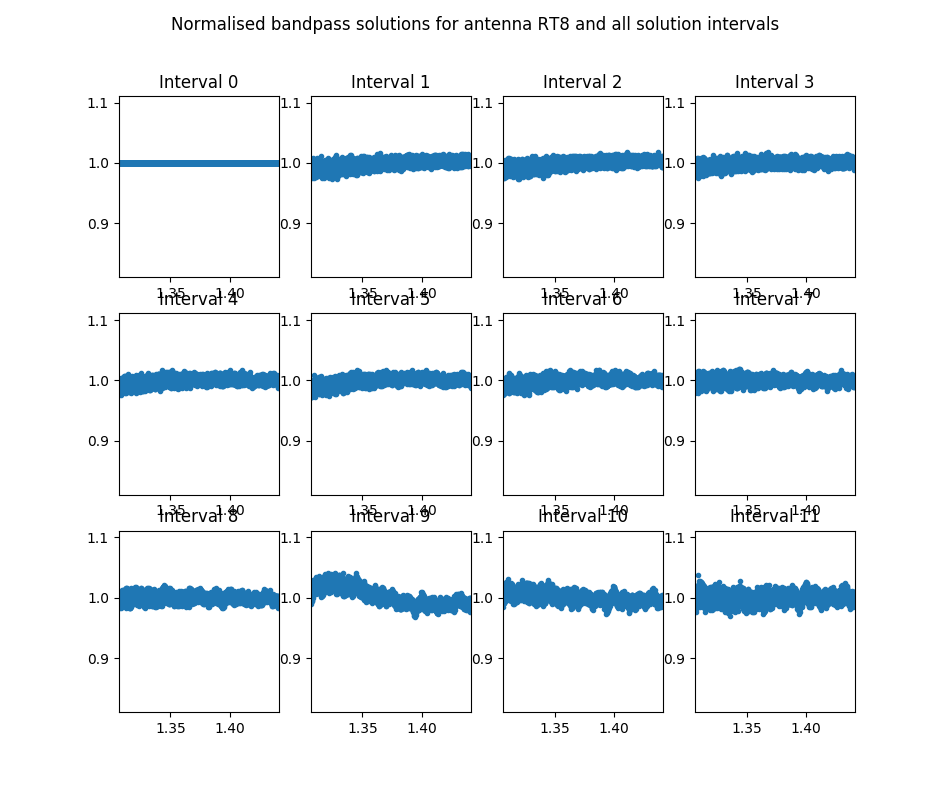

In [13]:
# Divide all solutions by the first solution interval to normalise
div = np.dstack([values[:,:,0]] * len(values[0,0]))
normvalues = values/div
# Then show the solutions for all solution intervals of one antenna
antenna = 'RT8' # You can change this one as you want
t = tnames.index(antenna)
plt.figure(figsize=(9.5,8))
plt.suptitle('Normalised bandpass solutions for antenna ' + antenna + ' and all solution intervals', fontsize='large')
for s in range(normvalues.shape[-1]):
    plt.subplot(np.ceil(normvalues.shape[-1]/4.0), 4, s+1)
    plt.scatter(freqs, normvalues[t,:,s],marker='.')
    plt.title('Interval ' + str(s))
    plt.xlim(np.min(freqs),np.max(freqs)) # Limit the plot to the minimum and maximum freqeuncies
    plt.ylim(np.nanmin(normvalues),np.nanmax(normvalues))
    plt.show()

/home/apercal/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


<IPython.core.display.Javascript object>


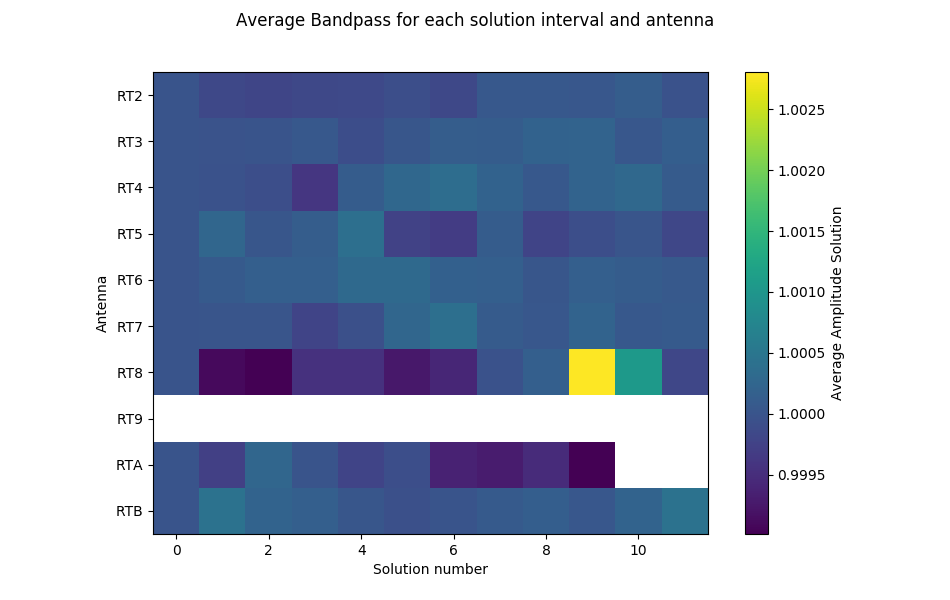

In [15]:
# Calculate the average over the frequency axis for each antenna and solution interval and visualise it in a plot
antaver = np.nanmean(normvalues,axis=1)
plt.figure(figsize=(9.5,6))
plt.suptitle('Average Bandpass for each solution interval and antenna', fontsize='large')
plt.imshow(antaver, interpolation='none')
plt.xlabel('Solution number')
plt.ylabel('Antenna')
plt.colorbar(label='Average Amplitude Solution')
plt.gca().set_yticks(range(len(tnames)))
plt.gca().set_yticklabels(tnames)
plt.show()

/home/apercal/pipeline/local/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


<IPython.core.display.Javascript object>


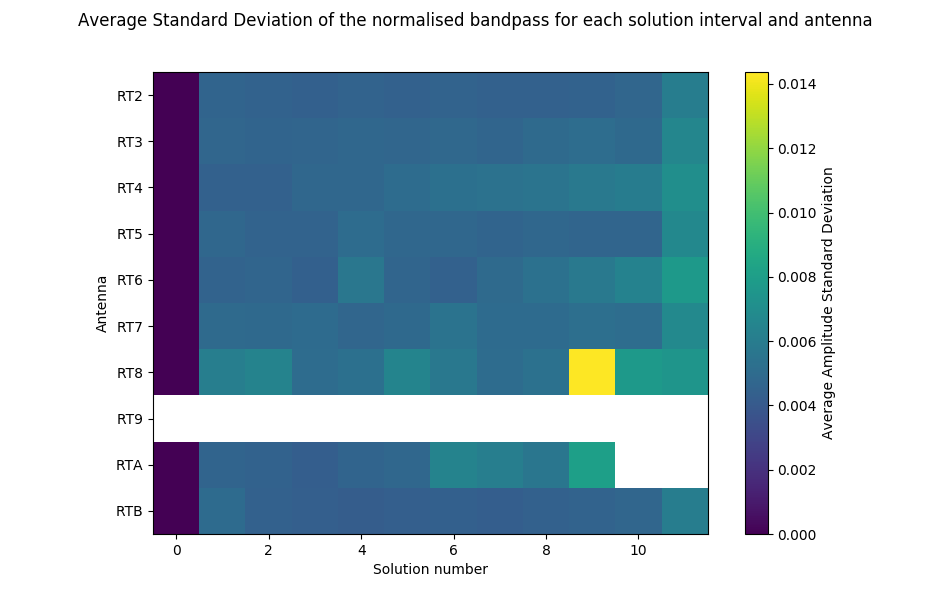

In [16]:
# Calculate the standard deviation over the freqeucny axis for each antenna and solution interval and visualise it in a plot
antstd = np.nanstd(normvalues,axis=1)
plt.figure(figsize=(9.5,6))
plt.suptitle('Average Standard Deviation of the normalised bandpass for each solution interval and antenna', fontsize='large')
plt.imshow(antstd, interpolation='none')
plt.xlabel('Solution number')
plt.ylabel('Antenna')
plt.colorbar(label='Average Amplitude Standard Deviation')
plt.gca().set_yticks(range(len(tnames)))
plt.gca().set_yticklabels(tnames)
plt.show()

<IPython.core.display.Javascript object>


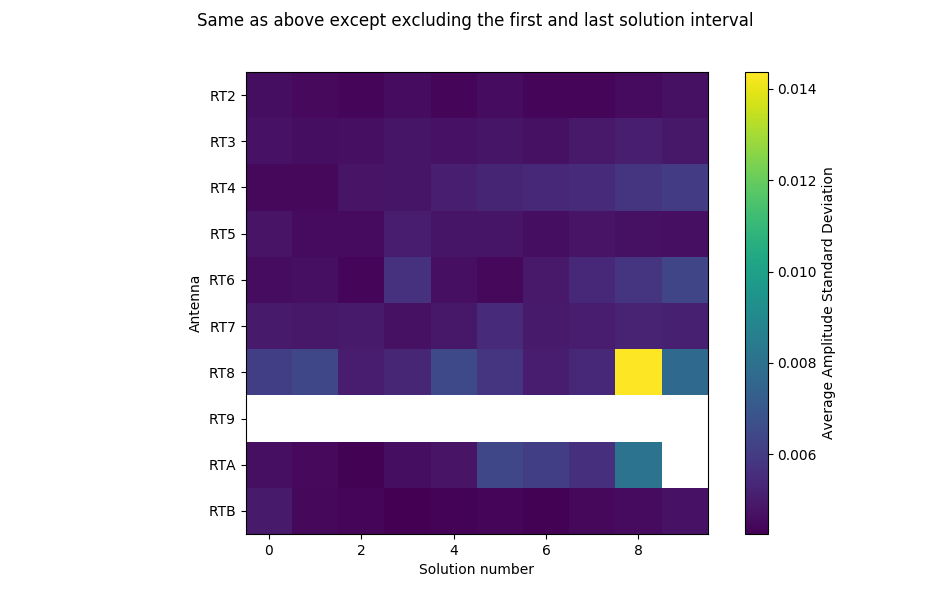

In [17]:
# If we exclude the first solution interval (it is the one we normalised with) and the last one (it is not a full one) we can make a plot with more contrast
antstd_noflsol = np.nanstd(normvalues[:,:,1:values.shape[-1]-1],axis=1)
plt.figure(figsize=(9.5,6))
plt.suptitle('Same as above except excluding the first and last solution interval', fontsize='large')
plt.imshow(antstd_noflsol, interpolation='none')
plt.xlabel('Solution number')
plt.ylabel('Antenna')
plt.colorbar(label='Average Amplitude Standard Deviation')
plt.gca().set_yticks(range(len(tnames)))
plt.gca().set_yticklabels(tnames)
plt.show()